## Building Models

### Import needed libraries

In [ ]:
import torch
from torch import nn
from torchvision import transforms as T
import gc

import time, datetime
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
from pathlib import Path
from collections import deque
import random, datetime, os, copy
import matplotlib.pyplot as plt

!pip install gym==0.17.3
import gym
!pip --disable-pip-version-check install -q nes_py
from nes_py.wrappers import JoypadSpace
!pip install gym-super-mario-bros
import gym_super_mario_bros
from gym_super_mario_bros.actions import SIMPLE_MOVEMENT
from gym_super_mario_bros.actions import COMPLEX_MOVEMENT

  Using cached gym_super_mario_bros-7.4.0-py3-none-any.whl (199 kB)


In [ ]:
print(gym.__version__)

0.17.3


### Initialize and check Environment 

In [ ]:
# Initialize Super Mario environment
env = gym_super_mario_bros.make("SuperMarioBros-1-1-v0")

env = JoypadSpace(env, SIMPLE_MOVEMENT)
env.reset()
next_state, reward, done, info = env.step(action=0)
print(f"{next_state.shape},\n {reward},\n {done},\n {info}")

(240, 256, 3),
 0.0,
 False,
 {'coins': 0, 'flag_get': False, 'life': 2, 'score': 0, 'stage': 1, 'status': 'small', 'time': 400, 'world': 1, 'x_pos': 40, 'y_pos': 79}


### Classes of wrappers that preprocess the environment

Here are some useful wrappers to preprocess the environment before feeding them to the network.
I found them from openAI baseline, they should be used for atari games but it would also be useful here.

In [ ]:
"""
Code from OpenAI baseline: https://github.com/openai/baselines/blob/master/baselines/common/atari_wrappers.py
"""

import os

import numpy as np

os.environ.setdefault("PATH", "")
from collections import deque

import cv2
import gym
from gym import spaces

cv2.ocl.setUseOpenCL(False)
from gym.wrappers import TimeLimit


class NoopResetEnv(gym.Wrapper):
    def __init__(self, env, noop_max=30):
        """Sample initial states by taking random number of no-ops on reset.
        No-op is assumed to be action 0.
        """
        gym.Wrapper.__init__(self, env)
        self.noop_max = noop_max
        self.override_num_noops = None
        self.noop_action = 0
        assert env.unwrapped.get_action_meanings()[0] == "NOOP"

    def reset(self, **kwargs):
        """Do no-op action for a number of steps in [1, noop_max]."""
        self.env.reset(**kwargs)
        if self.override_num_noops is not None:
            noops = self.override_num_noops
        else:
            noops = self.unwrapped.np_random.randint(
                1, self.noop_max + 1
            )  # pylint: disable=E1101
        assert noops > 0
        obs = None
        for _ in range(noops):
            obs, _, done, _ = self.env.step(self.noop_action)
            if done:
                obs = self.env.reset(**kwargs)
        return obs

    def step(self, ac):
        return self.env.step(ac)


class FireResetEnv(gym.Wrapper):
    def __init__(self, env):
        """Take action on reset for environments that are fixed until firing."""
        gym.Wrapper.__init__(self, env)
        assert env.unwrapped.get_action_meanings()[1] == "FIRE"
        assert len(env.unwrapped.get_action_meanings()) >= 3

    def reset(self, **kwargs):
        self.env.reset(**kwargs)
        obs, _, done, _ = self.env.step(1)
        if done:
            self.env.reset(**kwargs)
        obs, _, done, _ = self.env.step(2)
        if done:
            self.env.reset(**kwargs)
        return obs

    def step(self, ac):
        return self.env.step(ac)


class EpisodicLifeEnv(gym.Wrapper):
    def __init__(self, env):
        """Make end-of-life == end-of-episode, but only reset on true game over.
        Done by DeepMind for the DQN and co. since it helps value estimation.
        """
        gym.Wrapper.__init__(self, env)
        self.lives = 0
        self.was_real_done = True

    def step(self, action):
        obs, reward, done, info = self.env.step(action)
        self.was_real_done = done
        # check current lives, make loss of life terminal,
        # then update lives to handle bonus lives
        lives = self.env.unwrapped.ale.lives()
        if lives < self.lives and lives > 0:
            # for Qbert sometimes we stay in lives == 0 condition for a few frames
            # so it's important to keep lives > 0, so that we only reset once
            # the environment advertises done.
            done = True
        self.lives = lives
        return obs, reward, done, info

    def reset(self, **kwargs):
        """Reset only when lives are exhausted.
        This way all states are still reachable even though lives are episodic,
        and the learner need not know about any of this behind-the-scenes.
        """
        if self.was_real_done:
            obs = self.env.reset(**kwargs)
        else:
            # no-op step to advance from terminal/lost life state
            obs, _, _, _ = self.env.step(0)
        self.lives = self.env.unwrapped.ale.lives()
        return obs


class MaxAndSkipEnv(gym.Wrapper):
    def __init__(self, env, skip=4):
        """Return only every `skip`-th frame"""
        gym.Wrapper.__init__(self, env)
        # most recent raw observations (for max pooling across time steps)
        self._obs_buffer = np.zeros((2,) + env.observation_space.shape, dtype=np.uint8)
        self._skip = skip

    def step(self, action):
        """Repeat action, sum reward, and max over last observations."""
        total_reward = 0.0
        done = None
        for i in range(self._skip):
            obs, reward, done, info = self.env.step(action)
            if i == self._skip - 2:
                self._obs_buffer[0] = obs
            if i == self._skip - 1:
                self._obs_buffer[1] = obs
            total_reward += reward
            if done:
                break
        # Note that the observation on the done=True frame
        # doesn't matter
        max_frame = self._obs_buffer.max(axis=0)

        return max_frame, total_reward, done, info

    def reset(self, **kwargs):
        return self.env.reset(**kwargs)


class ClipRewardEnv(gym.RewardWrapper):
    def __init__(self, env):
        gym.RewardWrapper.__init__(self, env)

    def reward(self, reward):
        """Bin reward to {+1, 0, -1} by its sign."""
        return np.sign(reward)


class WarpFrame(gym.ObservationWrapper):
    def __init__(self, env, width=84, height=84, grayscale=True, dict_space_key=None):
        """
        Warp frames to 84x84 as done in the Nature paper and later work.
        If the environment uses dictionary observations, `dict_space_key` can be specified which indicates which
        observation should be warped.
        """
        super().__init__(env)
        self._width = width
        self._height = height
        self._grayscale = grayscale
        self._key = dict_space_key
        if self._grayscale:
            num_colors = 1
        else:
            num_colors = 3

        new_space = gym.spaces.Box(
            low=0,
            high=255,
            shape=(self._height, self._width, num_colors),
            dtype=np.uint8,
        )
        if self._key is None:
            original_space = self.observation_space
            self.observation_space = new_space
        else:
            original_space = self.observation_space.spaces[self._key]
            self.observation_space.spaces[self._key] = new_space
        assert original_space.dtype == np.uint8 and len(original_space.shape) == 3

    def observation(self, obs):
        if self._key is None:
            frame = obs
        else:
            frame = obs[self._key]

        if self._grayscale:
            frame = cv2.cvtColor(frame, cv2.COLOR_RGB2GRAY)
        frame = cv2.resize(
            frame, (self._width, self._height), interpolation=cv2.INTER_AREA
        )
        if self._grayscale:
            frame = np.expand_dims(frame, -1)

        if self._key is None:
            obs = frame
        else:
            obs = obs.copy()
            obs[self._key] = frame
        return obs


class FrameStack(gym.Wrapper):
    def __init__(self, env, k):
        """Stack k last frames.
        Returns lazy array, which is much more memory efficient.
        See Also
        --------
        baselines.common.atari_wrappers.LazyFrames
        """
        gym.Wrapper.__init__(self, env)
        self.k = k
        self.frames = deque([], maxlen=k)
        shp = env.observation_space.shape
        self.observation_space = spaces.Box(
            low=0,
            high=255,
            shape=(shp[:-1] + (shp[-1] * k,)),
            dtype=env.observation_space.dtype,
        )

    def reset(self):
        ob = self.env.reset()
        for _ in range(self.k):
            self.frames.append(ob)
        return self._get_ob()

    def step(self, action):
        ob, reward, done, info = self.env.step(action)
        self.frames.append(ob)
        return self._get_ob(), reward, done, info

    def _get_ob(self):
        assert len(self.frames) == self.k
        return LazyFrames(list(self.frames))


class ScaledFloatFrame(gym.ObservationWrapper):
    def __init__(self, env):
        gym.ObservationWrapper.__init__(self, env)
        self.observation_space = gym.spaces.Box(
            low=0, high=1, shape=env.observation_space.shape, dtype=np.float32
        )

    def observation(self, observation):
        # careful! This undoes the memory optimization, use
        # with smaller replay buffers only.
        return np.array(observation).astype(np.float32) / 255.0


class LazyFrames(object):
    def __init__(self, frames):
        """This object ensures that common frames between the observations are only stored once.
        It exists purely to optimize memory usage which can be huge for DQN's 1M frames replay
        buffers.
        This object should only be converted to numpy array before being passed to the model.
        You'd not believe how complex the previous solution was."""
        self._frames = frames
        self._out = None

    def _force(self):
        if self._out is None:
            self._out = np.concatenate(self._frames, axis=-1)
            self._frames = None
        return self._out

    def __array__(self, dtype=None):
        out = self._force()
        if dtype is not None:
            out = out.astype(dtype)
        return out

    def __len__(self):
        return len(self._force())

    def __getitem__(self, i):
        return self._force()[i]

    def count(self):
        frames = self._force()
        return frames.shape[frames.ndim - 1]

    def frame(self, i):
        return self._force()[..., i]


def make_atari(env_id, max_episode_steps=None):
    env = gym.make(env_id)
    assert "NoFrameskip" in env.spec.id
    env = NoopResetEnv(env, noop_max=30)
    env = MaxAndSkipEnv(env, skip=4)
    if max_episode_steps is not None:
        env = TimeLimit(env, max_episode_steps=max_episode_steps)
    return env


def wrap_deepmind(
    env, episode_life=True, clip_rewards=True, frame_stack=True, scale=True
):
    """Configure environment for DeepMind-style Atari."""
    if episode_life:
        env = EpisodicLifeEnv(env)
    if "FIRE" in env.unwrapped.get_action_meanings():
        env = FireResetEnv(env)
    env = WarpFrame(env)
    if scale:
        env = ScaledFloatFrame(env)
    if clip_rewards:
        env = ClipRewardEnv(env)
    if frame_stack:
        env = FrameStack(env, 4)
    return env


class episodic_life(gym.Wrapper):
    def __init__(self, env):
        """Wrap the environment to make losing a life equivalent to ending an episode,
        but only perform a full environment reset when it's an actual game over.
        This encourages the agent to learn to avoid dying while still allowing
        progress to be made in multi-life games.
        """
        super().__init__(env)  # Initialize the superclass with the environment
        self.lives = 0
        self.real_done = True  # Tracks if the last termination was a true game over

    def step(self, action):
        obs, reward, done, info = self.env.step(action)
        self.real_done = done
        current_lives = info.get('lives', 0)

        # If a life was lost (but not all), mark done as True (end of episode)
        if 0 < current_lives < self.lives:
            done = True
        self.lives = current_lives
        return obs, reward, done, info

    def reset(self, **kwargs):
        """Reset the environment fully if it was a real game over, otherwise
        simulate a step to move past the life loss without a full reset.
        """
        if self.real_done:
            obs = self.env.reset(**kwargs)
        else:
            # Simulate a no-op to bypass the life-loss state.
            obs, _, _, _ = self.env.step(0)
        self.lives = self.env.unwrapped._life
        return obs

In [ ]:
def preprocess(env):
    """Pick wrappers defined above to preprocess the environemnt.
    """
    env = NoopResetEnv(env, noop_max=30)
    env = MaxAndSkipEnv(env, skip=4)
    env = episodic_life(env)
    env = WarpFrame(env)
    env = ScaledFloatFrame(env)
    env = FrameStack(env, 4)
    return env


def arrange(state):
    """
    Preprocess a single image state for input into a network(CNN).
    """
    if not isinstance(state, np.ndarray):
        state = np.array(state)
    assert len(state.shape) == 3
    return np.expand_dims(np.transpose(state, (2, 0, 1)), 0)  # permute the orientation of state, to channels, height, width

### Old wrappers I've tried, which are not good enough

In [ ]:
class SkipFrames(gym.Wrapper):
    '''
        A wrapper that return only every skip nth frame.
    '''
    def __init__(self, env, skip):
        super().__init__(env)
        self._skip = skip

    def step(self, action):
        total_reward = 0.0
        done = False
        for i in range(self._skip):
            obs, reward, done, info = self.env.step(action)
            total_reward += reward
            if done:
                break
        return obs, total_reward, done, info

class PreProcessold(gym.ObservationWrapper):
    '''
    Wrapper to transform an RGB image to grayscale, resize it, and normalize the pixel values.
    '''
    def __init__(self, env, new_shape):
        super().__init__(env)
        # Setup the new shape: if the shape is a single int, we make it a square shape
        if isinstance(new_shape, int):
            self.new_shape = (new_shape, new_shape)
        else:
            self.new_shape = tuple(new_shape)

        # Update observation space to reflect grayscale (single channel) and new shape
        obs_shape = self.new_shape + (1,)  # Adding grayscale channel
        self.observation_space = Box(low=0.0, high=1.0, shape=obs_shape, dtype=np.float32)

        # Setup the transform pipeline: convert to grayscale, resize, then normalize
        self.transform = T.Compose([
            T.Grayscale(),  # Convert RGB to Grayscale
            T.Resize(self.new_shape),  # Resize the image
            T.Normalize(0, 255)
        ])

    def permute_orientation(self, observation):
        # Adjust the orientation for PyTorch: Channel x Height x Width
        observation = np.transpose(observation, (2, 0, 1))
        return torch.tensor(observation.copy(), dtype=torch.float)

    def observation(self, observation):
        # Apply the permute orientation to adjust the image tensor shape and normalize
        observation = self.permute_orientation(observation)
        # Apply the transformations: Grayscale and Resize
        observation = self.transform(observation)
        return observation.squeeze(0)

# env = SkipFrame(env, skip=4) # Skip several frames
# env = PreProcess(env, 84) # GrayScale and Downsample the state
# env = FrameStack(env, num_stack=4) #

### Use wrappers to preprocess the environment and check how does it look like now:

In [ ]:
env = preprocess(env)
state = arrange(env.reset())
state

array([[[[0.54901963, 0.54901963, 0.54901963, ..., 0.54901963,
          0.54901963, 0.54901963],
         [0.54901963, 0.54901963, 0.54901963, ..., 0.54901963,
          0.54901963, 0.54901963],
         [0.54901963, 0.54901963, 0.54901963, ..., 0.54901963,
          0.54901963, 0.54901963],
         ...,
         [0.5568628 , 0.4862745 , 0.4509804 , ..., 0.34901962,
          0.5764706 , 0.3254902 ],
         [0.5176471 , 0.36862746, 0.3372549 , ..., 0.42745098,
          0.49411765, 0.3254902 ],
         [0.44705883, 0.3882353 , 0.47058824, ..., 0.44313726,
          0.31764707, 0.21176471]],

        [[0.54901963, 0.54901963, 0.54901963, ..., 0.54901963,
          0.54901963, 0.54901963],
         [0.54901963, 0.54901963, 0.54901963, ..., 0.54901963,
          0.54901963, 0.54901963],
         [0.54901963, 0.54901963, 0.54901963, ..., 0.54901963,
          0.54901963, 0.54901963],
         ...,
         [0.5568628 , 0.4862745 , 0.4509804 , ..., 0.34901962,
          0.5764706 , 0.3

### Dueling DQN Class

In [ ]:
def init_weights(m):
    if isinstance(m, nn.Conv2d) or isinstance(m, nn.Linear):
        nn.init.xavier_uniform_(m.weight)
        nn.init.constant_(m.bias, 0)

class DQN(nn.Module):
    def __init__(self, input_dim, output_dim, use_cuda):
        super(DQN, self).__init__()
        c, w, h = input_dim
        self.use_cuda = use_cuda
        self.feature = nn.Sequential(
            nn.Conv2d(in_channels=c, out_channels=32, kernel_size=8, stride=4),
            nn.ReLU(),
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1),
            nn.ReLU(),
            nn.Flatten()
        )

        self.advantage = nn.Sequential( # Stream for advantage
            nn.Linear(20736, 512),
            nn.ReLU(),
            nn.Linear(512, output_dim)
        )

        self.value = nn.Sequential( # Streasm for value
            nn.Linear(20736, 512),
            nn.ReLU(),
            nn.Linear(512, 1)
        )


        for m in self.modules():
            if isinstance(m, nn.Conv2d) or isinstance(m, nn.Linear): # initialize weights
                nn.init.xavier_uniform_(m.weight)
                nn.init.constant_(m.bias, 0.01)

    def forward(self, input):
        if type(input) != torch.Tensor:
            input = torch.FloatTensor(input)
            if self.use_cuda:
                input = input.to(device="cuda")
        features = self.feature(input)

        adv = self.advantage(features)
        val = self.value(features)

        q = val + (adv - adv.mean(dim=1, keepdim=True))
        return q

### DQN Agent Class

In [ ]:
class DQNAgent:
    def __init__(self, state_dim, action_dim, use_cuda, eps, decay, gamma, alpha, optimizer, loss):
        self.state_dim = state_dim
        self.action_dim = action_dim
        self.use_cuda = use_cuda
        self.memory = deque(maxlen=100000)
        self.batch_size = 256

        self.policy = DQN(self.state_dim, self.action_dim, use_cuda)
        self.target = DQN(self.state_dim, self.action_dim, use_cuda)
        if self.use_cuda:
            self.policy = self.policy.to(device="cuda")
            self.target = self.target.to(device="cuda")

        self.exploration_rate = eps
        self.exploration_rate_decay = decay
        self.exploration_rate_min = 0.05
        self.curr_step = 0

        self.gamma = gamma
        if optimizer == "Adam":
            self.optimizer = torch.optim.Adam(self.policy.parameters(), lr=alpha)
        else:
            self.optimizer = torch.optim.SGD(self.policy.parameters(), lr=alpha, momentum=0.9)

        if loss == "MSE":
            self.loss_fn = torch.nn.MSELoss()
        elif loss == "Huber":
            self.loss_fn = torch.nn.HuberLoss()
        else:
            self.loss_fn = torch.nn.SmoothL1Loss()
        self.burnin = 2000 # min. experiences before training
        self.learn_every = 3  # no. of experiences between updates to Q_online
        self.sync_every = 1e4  # no. of experiences between Q_target & Q_online sync


    def select_action(self, state, greedy=False):
        if greedy:
          if self.use_cuda:
              action = np.argmax(self.policy(state).cpu().detach().numpy())
          else:
              action = np.argmax(self.policy(state).detach().numpy())
          return action
        else:
          # exploration
          if np.random.rand() < self.exploration_rate:
              action = np.random.randint(self.action_dim)

          # exploitation
          else:
              if self.use_cuda:
                  action = np.argmax(self.policy(state).cpu().detach().numpy())
              else:
                  action = np.argmax(self.policy(state).detach().numpy())
          self.curr_step += 1
          return action


    def remember(self, state, next_state, action, reward, done):
        self.memory.append((state, next_state, action, reward, done))


    def recall(self):
        batch = random.sample(self.memory, self.batch_size)
        state, next_state, action, reward, done =  list(map(list, zip(*batch)))
        state = np.array(state).squeeze()
        next_state = np.array(next_state).squeeze()
        action = torch.tensor(action).unsqueeze(-1)
        reward = torch.FloatTensor(reward).unsqueeze(-1)
        done = torch.FloatTensor(done).unsqueeze(-1)
        if self.use_cuda:
            action = action.to(device="cuda")
            reward = reward.to(device="cuda")
            done = done.to(device="cuda")
        return state, next_state, action, reward, done


    @torch.no_grad()
    def td_target(self, reward, next_state, done):
        next_Q = self.target(next_state).max(1)[0].unsqueeze(-1)
        return (reward + self.gamma * next_Q * (1 - done))


    def update(self, td_estimate, td_target):
        loss = self.loss_fn(td_estimate, td_target)
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()
        return loss.item()



    def learn(self):
        if self.curr_step < self.burnin: return None, None
        if self.curr_step % self.sync_every == 0: self.target.load_state_dict(self.policy.state_dict())
        if self.curr_step % self.learn_every != 0: return None, None


        # Sample from memory
        state, next_state, action, reward, done = self.recall()

        # Get TD Estimate
        td_est = torch.gather(self.policy(state), dim=1, index=action.view(-1, 1).long())
        # Get TD Target
        td_tgt = self.td_target(reward, next_state, done)

        # Backpropagate loss through Q_online
        loss = self.update(td_est, td_tgt)

        return (td_est.mean().item(), loss)

### Double DQN Agent Class

In [ ]:
class DoubleDQNAgent:
    def __init__(self, state_dim, action_dim, use_cuda, eps, decay, gamma, alpha, optimizer, loss):
        self.state_dim = state_dim
        self.action_dim = action_dim
        self.use_cuda = use_cuda
        self.memory = deque(maxlen=100000)
        self.batch_size = 256

        self.policy = DQN(self.state_dim, self.action_dim, use_cuda)
        self.target = DQN(self.state_dim, self.action_dim, use_cuda)
        if self.use_cuda:
            self.policy = self.policy.to(device="cuda")
            self.target = self.target.to(device="cuda")

        self.exploration_rate = eps
        self.exploration_rate_decay = decay
        self.exploration_rate_min = 0.05
        self.curr_step = 0

        self.gamma = gamma
        if optimizer == "Adam":
            self.optimizer = torch.optim.Adam(self.policy.parameters(), lr=alpha)
        else:
            self.optimizer = torch.optim.SGD(self.policy.parameters(), lr=alpha, momentum=0.9)

        if loss == "MSE":
            self.loss_fn = torch.nn.MSELoss()
        elif loss == "Huber":
            self.loss_fn = torch.nn.HuberLoss()
        else:
            self.loss_fn = torch.nn.SmoothL1Loss()
        self.burnin = 2000 # min. experiences before training
        self.learn_every = 3  # no. of experiences between updates to Q_online
        self.sync_every = 1e4  # no. of experiences between Q_target & Q_online sync


    def select_action(self, state, greedy=False):
        if greedy:
          if self.use_cuda:
              action = np.argmax(self.policy(state).cpu().detach().numpy())
          else:
              action = np.argmax(self.policy(state).detach().numpy())
          return action
        else:
          # exploration
          if np.random.rand() < self.exploration_rate:
              action = np.random.randint(self.action_dim)

          # exploitation
          else:
              if self.use_cuda:
                  action = np.argmax(self.policy(state).cpu().detach().numpy())
              else:
                  action = np.argmax(self.policy(state).detach().numpy())
          self.curr_step += 1
          return action


    def remember(self, state, next_state, action, reward, done):
        self.memory.append((state, next_state, action, reward, done))


    def recall(self):
        batch = random.sample(self.memory, self.batch_size)
        state, next_state, action, reward, done =  list(map(list, zip(*batch)))
        state = np.array(state).squeeze()
        next_state = np.array(next_state).squeeze()
        action = torch.tensor(action).unsqueeze(-1)
        reward = torch.FloatTensor(reward).unsqueeze(-1)
        done = torch.FloatTensor(done).unsqueeze(-1)
        if self.use_cuda:
            action = action.to(device="cuda")
            reward = reward.to(device="cuda")
            done = done.to(device="cuda")
        return state, next_state, action, reward, done


    @torch.no_grad()
    def td_target(self, reward, next_state, done):
        best_action = self.policy(next_state).max(1)[1].unsqueeze(-1)
        next_Q = self.target(next_state).gather(1, best_action)
        return (reward + self.gamma * next_Q * (1-done))


    def update(self, td_estimate, td_target):
        loss = self.loss_fn(td_estimate, td_target)
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()
        return loss.item()



    def learn(self):
        if self.curr_step < self.burnin: return None, None
        if self.curr_step % self.sync_every == 0: self.target.load_state_dict(self.policy.state_dict())
        if self.curr_step % self.learn_every != 0: return None, None


        # Sample from memory
        state, next_state, action, reward, done = self.recall()

        # Get TD Estimate
        td_est = torch.gather(self.policy(state), dim=1, index=action.view(-1, 1).long())
        # Get TD Target
        td_tgt = self.td_target(reward, next_state, done)

        # Backpropagate loss through Q_online
        loss = self.update(td_est, td_tgt)

        return (td_est.mean().item(), loss)

## Experiments

### Compare Adam and SGD optimizer for DQN

#### Adam

In [ ]:
use_cuda = torch.cuda.is_available()
env = gym_super_mario_bros.make("SuperMarioBros-1-1-v0")
env = JoypadSpace(env, SIMPLE_MOVEMENT)
env = preprocess(env)
state = env.reset()
agent_dqn_adam_l1 = DQNAgent((4, 84, 84), env.action_space.n, use_cuda, 1.0, 0.9995, 0.99, 0.0005, "Adam", "L1")
episodes = 7000
rewards_dqn_adam_l1 = []
for e in range(episodes):

    state = arrange(env.reset())
    agent_dqn_adam_l1.exploration_rate *= agent_dqn_adam_l1.exploration_rate_decay
    agent_dqn_adam_l1.exploration_rate = max(agent_dqn_adam_l1.exploration_rate_min, agent_dqn_adam_l1.exploration_rate)
    r = 0
    while True:
        action = agent_dqn_adam_l1.select_action(state)
        next_state, reward, done, info = env.step(action)
        next_state = arrange(next_state)
        r += reward
        reward_modified = np.sign(reward) * (np.sqrt(np.abs(reward) + 1) - 1) + 0.001 * reward # Smoothing the reward
        agent_dqn_adam_l1.remember(state, next_state, int(action), float(reward_modified), int(done))
        q, loss = agent_dqn_adam_l1.learn()
        state = next_state
        if done or info["flag_get"]:
            break
    rewards_dqn_adam_l1.append(r)
np.save("rewards_dqn_adam_l1.npy", rewards_dqn_adam_l1)
torch.save(agent_dqn_adam_l1.policy.state_dict(), 'agent_dqn_adam_l1_policy.pth')

#### SGD

In [ ]:
use_cuda = torch.cuda.is_available()
env = gym_super_mario_bros.make("SuperMarioBros-1-1-v0")
env = JoypadSpace(env, SIMPLE_MOVEMENT)
env = preprocess(env)
state = env.reset()
agent_dqn_sgd_l1 = DQNAgent((4, 84, 84), env.action_space.n, use_cuda, 1.0, 0.9995, 0.99, 0.0005, "SGD", "L1")
episodes = 7000
rewards_dqn_sgd_l1 = []
for e in range(episodes):

    state = arrange(env.reset())
    agent_dqn_sgd_l1.exploration_rate *= agent_dqn_sgd_l1.exploration_rate_decay
    agent_dqn_sgd_l1.exploration_rate = max(agent_dqn_sgd_l1.exploration_rate_min, agent_dqn_sgd_l1.exploration_rate)
    # Play the game!
    r = 0
    while True:
        action = agent_dqn_sgd_l1.select_action(state)
        next_state, reward, done, info = env.step(action)
        next_state = arrange(next_state)
        r += reward
        reward_modified = np.sign(reward) * (np.sqrt(np.abs(reward) + 1) - 1) + 0.001 * reward # Smoothing the reward
        agent_dqn_sgd_l1.remember(state, next_state, int(action), float(reward_modified), int(done))
        q, loss = agent_dqn_sgd_l1.learn()
        state = next_state
        if done or info["flag_get"]:
            break
    rewards_dqn_sgd_l1.append(r)
np.save("rewards_dqn_sgd_l1.npy", rewards_dqn_sgd_l1)
torch.save(agent_dqn_sgd_l1.policy.state_dict(), 'agent_dqn_sgd_l1_policy.pth')

#### Plot

In [ ]:
rewards_dqn_adam_l1 = np.load('rewards_dqn_adam_l1.npy')
mean_rewards_dqn_adam_l1 = np.zeros(7000)
for i in range(7000):
    mean_rewards_dqn_adam_l1[i] = np.mean(rewards_dqn_adam_l1[max(0, i-100):(i+1)])


rewards_dqn_sgd_l1 = np.load('rewards_dqn_sgd_l1.npy')
mean_rewards_dqn_sgd_l1 = np.zeros(7000)
for i in range(7000):
    mean_rewards_dqn_sgd_l1[i] = np.mean(rewards_dqn_sgd_l1[max(0, i-100):(i+1)])

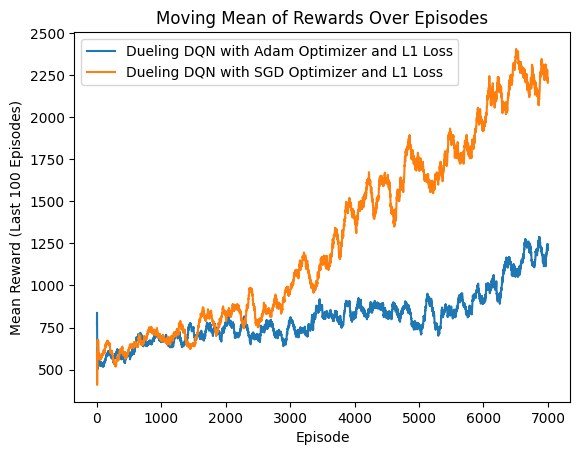

In [ ]:
plt.clf()
plt.plot(range(7000), mean_rewards_dqn_adam_l1, label = "Dueling DQN with Adam Optimizer and L1 Loss")
plt.plot(range(7000), mean_rewards_dqn_sgd_l1, label = "Dueling DQN with SGD Optimizer and L1 Loss")
plt.xlabel('Episode')
plt.ylabel('Mean Reward (Last 100 Episodes)')
plt.title('Moving Mean of Rewards Over Episodes')
plt.legend()
plt.show()

### Compare SmoothL1 loss and Huber loss for DQN

#### SmoothL1 Loss

In [ ]:
# use_cuda = torch.cuda.is_available()
# env = gym_super_mario_bros.make("SuperMarioBros-1-1-v0")
# env = JoypadSpace(env, SIMPLE_MOVEMENT)
# env = preprocess(env)
# state = env.reset()
# agent_dqn_sgd_l1 = DQNAgent((4, 84, 84), env.action_space.n, use_cuda, 1.0, 0.9995, 0.99, 0.0005, "SGD", "L1")
# episodes = 7000
# rewards_dqn_sgd_l1 = []
# for e in range(episodes):

#     state = arrange(env.reset())
#     agent_dqn_sgd_l1.exploration_rate *= agent_dqn_sgd_l1.exploration_rate_decay
#     agent_dqn_sgd_l1.exploration_rate = max(agent_dqn_sgd_l1.exploration_rate_min, agent_dqn_sgd_l1.exploration_rate)
#     # Play the game!
#     r = 0
#     while True:
#         action = agent_dqn_sgd_l1.select_action(state)
#         next_state, reward, done, info = env.step(action)
#         next_state = arrange(next_state)
#         r += reward
#         reward_modified = np.sign(reward) * (np.sqrt(np.abs(reward) + 1) - 1) + 0.001 * reward # Smoothing the reward
#         agent_dqn_sgd_l1.remember(state, next_state, int(action), float(reward_modified), int(done))
#         q, loss = agent_dqn_sgd_l1.learn()
#         state = next_state
#         if done or info["flag_get"]:
#             break
#     rewards_dqn_sgd_l1.append(r)
# np.save("rewards_dqn_sgd_l1.npy", rewards_dqn_sgd_l1)
# torch.save(agent_dqn_sgd_l1.policy.state_dict(), 'agent_dqn_sgd_l1_policy.pth')

#### Huber Loss

In [ ]:
use_cuda = torch.cuda.is_available()
env = gym_super_mario_bros.make("SuperMarioBros-1-1-v0")
env = JoypadSpace(env, SIMPLE_MOVEMENT)
env = preprocess(env)
state = env.reset()
agent_dqn_sgd_huber = DQNAgent((4, 84, 84), env.action_space.n, use_cuda, 1.0, 0.9995, 0.99, 0.0005, "SGD", "Huber")
episodes = 7000
rewards_dqn_sgd_huber = []
for e in range(episodes):
    state = arrange(env.reset())
    agent_dqn_sgd_huber.exploration_rate *= agent_dqn_sgd_huber.exploration_rate_decay
    agent_dqn_sgd_huber.exploration_rate = max(agent_dqn_sgd_huber.exploration_rate_min, agent_dqn_sgd_huber.exploration_rate)
    r = 0
    while True:
        action = agent_dqn_sgd_huber.select_action(state)
        next_state, reward, done, info = env.step(action)
        next_state = arrange(next_state)
        r += reward
        reward_modified = np.sign(reward) * (np.sqrt(np.abs(reward) + 1) - 1) + 0.001 * reward # Smoothing the reward
        agent_dqn_sgd_huber.remember(state, next_state, int(action), float(reward_modified), int(done))
        q, loss = agent_dqn_sgd_huber.learn()
        state = next_state
        if done or info["flag_get"]:
            break
    rewards_dqn_sgd_huber.append(r)
np.save("rewards_dqn_sgd_huber.npy", rewards_dqn_sgd_huber)
torch.save(agent_dqn_sgd_huber.policy.state_dict(), 'agent_dqn_sgd_huber_policy.pth')

#### Plot

In [ ]:
rewards_dqn_sgd_l1 = np.load('rewards_dqn_sgd_l1.npy')
mean_rewards_dqn_sgd_l1 = np.zeros(7000)
for i in range(7000):
    mean_rewards_dqn_sgd_l1[i] = np.mean(rewards_dqn_sgd_l1[max(0, i-100):(i+1)])

rewards_dqn_sgd_huber = np.load('rewards_dqn_sgd_huber.npy')
mean_rewards_dqn_sgd_huber = np.zeros(7000)
for i in range(7000):
    mean_rewards_dqn_sgd_huber[i] = np.mean(rewards_dqn_sgd_huber[max(0, i-100):(i+1)])

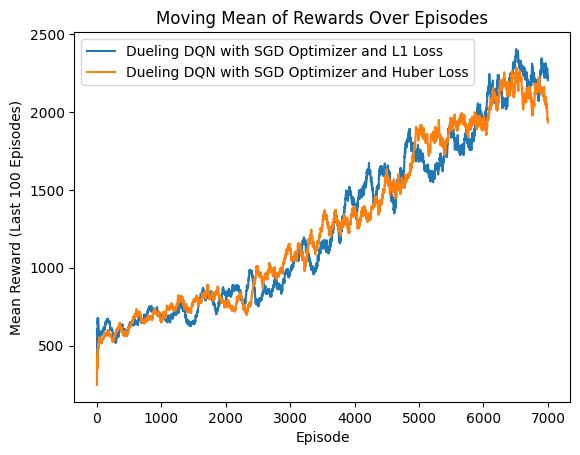

In [ ]:
plt.clf()
plt.plot(range(7000), mean_rewards_dqn_sgd_l1, label = "Dueling DQN with SGD Optimizer and L1 Loss")
plt.plot(range(7000), mean_rewards_dqn_sgd_huber, label = "Dueling DQN with SGD Optimizer and Huber Loss")
plt.xlabel('Episode')
plt.ylabel('Mean Reward (Last 100 Episodes)')
plt.title('Moving Mean of Rewards Over Episodes')
plt.legend()
plt.show()

### Compare Adam and SGD optimizer for double DQN

#### Adam

In [ ]:
use_cuda = torch.cuda.is_available()
env = gym_super_mario_bros.make("SuperMarioBros-1-1-v0")
env = JoypadSpace(env, SIMPLE_MOVEMENT)
env = preprocess(env)
state = env.reset()
agent_double_dqn_adam_l1 = DoubleDQNAgent((4, 84, 84), env.action_space.n, use_cuda, 1.0, 0.9995, 0.99, 0.0005, "Adam", "L1")
episodes = 7000
rewards_double_dqn_adam_l1 = []
for e in range(episodes):
    state = arrange(env.reset())
    agent_double_dqn_adam_l1.exploration_rate *= agent_double_dqn_adam_l1.exploration_rate_decay
    agent_double_dqn_adam_l1.exploration_rate = max(agent_double_dqn_adam_l1.exploration_rate_min, agent_double_dqn_adam_l1.exploration_rate)
    r = 0
    while True:
        action = agent_double_dqn_adam_l1.select_action(state)
        next_state, reward, done, info = env.step(action)
        next_state = arrange(next_state)
        r += reward
        reward_modified = np.sign(reward) * (np.sqrt(np.abs(reward) + 1) - 1) + 0.001 * reward # Smoothing the reward
        agent_double_dqn_adam_l1.remember(state, next_state, int(action), float(reward_modified), int(done))
        q, loss = agent_double_dqn_adam_l1.learn()
        state = next_state
        if done or info["flag_get"]:
            break
    rewards_double_dqn_adam_l1.append(r)
np.save("rewards_double_dqn_adam_l1.npy", rewards_double_dqn_adam_l1)
torch.save(agent_double_dqn_adam_l1.policy.state_dict(), 'agent_double_dqn_adam_l1_policy.pth')

#### SGD

In [ ]:
use_cuda = torch.cuda.is_available()
env = gym_super_mario_bros.make("SuperMarioBros-1-1-v0")
env = JoypadSpace(env, SIMPLE_MOVEMENT)
env = preprocess(env)
state = env.reset()
agent_double_dqn_sgd_l1 = DoubleDQNAgent((4, 84, 84), env.action_space.n, use_cuda, 1.0, 0.9995, 0.99, 0.0005, "SGD", "L1")
episodes = 7000
rewards_double_dqn_sgd_l1 = []
for e in range(episodes):
    state = arrange(env.reset())
    agent_double_dqn_sgd_l1.exploration_rate *= agent_double_dqn_sgd_l1.exploration_rate_decay
    agent_double_dqn_sgd_l1.exploration_rate = max(agent_double_dqn_sgd_l1.exploration_rate_min, agent_double_dqn_sgd_l1.exploration_rate)
    r = 0
    while True:
        action = agent_double_dqn_sgd_l1.select_action(state)
        next_state, reward, done, info = env.step(action)
        next_state = arrange(next_state)
        r += reward
        reward_modified = np.sign(reward) * (np.sqrt(np.abs(reward) + 1) - 1) + 0.001 * reward # Smoothing the reward
        agent_double_dqn_sgd_l1.remember(state, next_state, int(action), float(reward_modified), int(done))
        q, loss = agent_double_dqn_sgd_l1.learn()
        state = next_state
        if done or info["flag_get"]:
            break
    rewards_double_dqn_sgd_l1.append(r)
np.save("rewards_double_dqn_sgd_l1.npy", rewards_double_dqn_sgd_l1)
torch.save(agent_double_dqn_sgd_l1.policy.state_dict(), 'agent_double_dqn_sgd_l1_policy.pth')

#### Plot

In [ ]:
rewards_double_dqn_adam_l1 = np.load('rewards_double_dqn_adam_l1.npy')
mean_rewards_double_dqn_adam_l1 = np.zeros(7000)
for i in range(7000):
    mean_rewards_double_dqn_adam_l1[i] = np.mean(rewards_double_dqn_adam_l1[max(0, i-100):(i+1)])


rewards_double_dqn_sgd_l1 = np.load('rewards_double_dqn_sgd_l1.npy')
mean_rewards_double_dqn_sgd_l1 = np.zeros(7000)
for i in range(7000):
    mean_rewards_double_dqn_sgd_l1[i] = np.mean(rewards_double_dqn_sgd_l1[max(0, i-100):(i+1)])

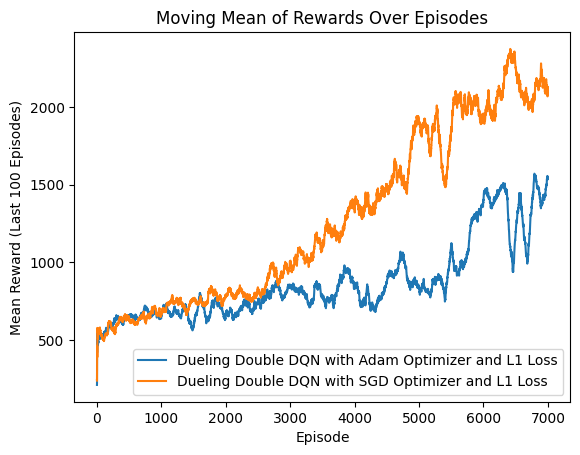

In [ ]:
plt.clf()
plt.plot(range(7000), mean_rewards_double_dqn_adam_l1, label = "Dueling Double DQN with Adam Optimizer and L1 Loss")
plt.plot(range(7000), mean_rewards_double_dqn_sgd_l1, label = "Dueling Double DQN with SGD Optimizer and L1 Loss")
plt.xlabel('Episode')
plt.ylabel('Mean Reward (Last 100 Episodes)')
plt.title('Moving Mean of Rewards Over Episodes')
plt.legend()
plt.show()

### Compare SmoothL1 loss and Huber loss for double DQN

#### SmoothL1 Loss

In [ ]:
# use_cuda = torch.cuda.is_available()
# env = gym_super_mario_bros.make("SuperMarioBros-1-1-v0")
# env = JoypadSpace(env, SIMPLE_MOVEMENT)
# env = preprocess(env)
# state = env.reset()
# agent_double_dqn_sgd_l1 = DoubleDQNAgent((4, 84, 84), env.action_space.n, use_cuda, 1.0, 0.9995, 0.99, 0.0005, "SGD", "L1")
# episodes = 7000
# rewards_double_dqn_sgd_l1 = []
# for e in range(episodes):
#     state = arrange(env.reset())
#     agent_double_dqn_sgd_l1.exploration_rate *= agent_double_dqn_sgd_l1.exploration_rate_decay
#     agent_double_dqn_sgd_l1.exploration_rate = max(agent_double_dqn_sgd_l1.exploration_rate_min, agent_double_dqn_sgd_l1.exploration_rate)
#     r = 0
#     while True:
#         action = agent_double_dqn_sgd_l1.select_action(state)
#         next_state, reward, done, info = env.step(action)
#         next_state = arrange(next_state)
#         r += reward
#         reward_modified = np.sign(reward) * (np.sqrt(np.abs(reward) + 1) - 1) + 0.001 * reward # Smoothing the reward
#         agent_double_dqn_sgd_l1.remember(state, next_state, int(action), float(reward_modified), int(done))
#         q, loss = agent_double_dqn_sgd_l1.learn()
#         state = next_state
#         if done or info["flag_get"]:
#             break
#     rewards_double_dqn_sgd_l1.append(r)
# np.save("rewards_double_dqn_sgd_l1.npy", rewards_double_dqn_sgd_l1)
# torch.save(agent_double_dqn_sgd_l1.policy.state_dict(), 'agent_double_dqn_sgd_l1_policy.pth')

#### Huber Loss

In [ ]:
use_cuda = torch.cuda.is_available()
env = gym_super_mario_bros.make("SuperMarioBros-1-1-v0")
env = JoypadSpace(env, SIMPLE_MOVEMENT)
env = preprocess(env)
state = env.reset()
agent_double_dqn_sgd_huber = DoubleDQNAgent((4, 84, 84), env.action_space.n, use_cuda, 1.0, 0.9995, 0.99, 0.0005, "SGD", "Huber")
episodes = 7000
rewards_double_dqn_sgd_huber = []
for e in range(episodes):
    state = arrange(env.reset())
    agent_double_dqn_sgd_huber.exploration_rate *= agent_double_dqn_sgd_huber.exploration_rate_decay
    agent_double_dqn_sgd_huber.exploration_rate = max(agent_double_dqn_sgd_huber.exploration_rate_min, agent_double_dqn_sgd_huber.exploration_rate)
    r = 0
    while True:
        action = agent_double_dqn_sgd_huber.select_action(state)
        next_state, reward, done, info = env.step(action)
        next_state = arrange(next_state)
        r += reward
        reward_modified = np.sign(reward) * (np.sqrt(np.abs(reward) + 1) - 1) + 0.001 * reward # Smoothing the reward
        agent_double_dqn_sgd_huber.remember(state, next_state, int(action), float(reward_modified), int(done))
        q, loss = agent_double_dqn_sgd_huber.learn()
        state = next_state
        if done or info["flag_get"]:
            break
    rewards_double_dqn_sgd_huber.append(r)

np.save("rewards_double_dqn_sgd_huber.npy", rewards_double_dqn_sgd_huber)
torch.save(agent_double_dqn_sgd_huber.policy.state_dict(), 'agent_double_dqn_sgd_huber_policy.pth')

#### Plot

In [36]:
# First 2000 episode only for simplicity.
rewards_double_dqn_sgd_l1 = np.load('rewards_double_dqn_sgd_l1.npy')
mean_rewards_double_dqn_sgd_l1 = np.zeros(2000)
for i in range(2000):
    mean_rewards_double_dqn_sgd_l1[i] = np.mean(rewards_double_dqn_sgd_l1[max(0, i-100):(i+1)])

rewards_double_dqn_sgd_huber = np.load('rewards_double_dqn_sgd_huber.npy')
mean_rewards_double_dqn_sgd_huber = np.zeros(2000)
for i in range(2000):
    mean_rewards_double_dqn_sgd_huber[i] = np.mean(rewards_double_dqn_sgd_huber[max(0, i-100):(i+1)])


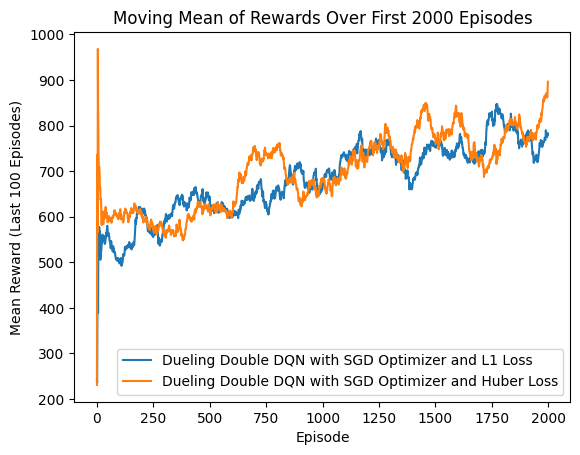

In [37]:
plt.clf()
plt.plot(range(2000), mean_rewards_double_dqn_sgd_l1, label = "Dueling Double DQN with SGD Optimizer and L1 Loss")
plt.plot(range(2000), mean_rewards_double_dqn_sgd_huber, label = "Dueling Double DQN with SGD Optimizer and Huber Loss")
plt.xlabel('Episode')
plt.ylabel('Mean Reward (Last 100 Episodes)')
plt.title('Moving Mean of Rewards Over First 2000 Episodes')
plt.legend()
plt.show()

### Compare DQN and Double DQN

#### DQN

In [ ]:
use_cuda = torch.cuda.is_available()
env = gym_super_mario_bros.make("SuperMarioBros-1-1-v0")
env = JoypadSpace(env, SIMPLE_MOVEMENT)
env = preprocess(env)
state = env.reset()
agent_dqn_sgd_l1 = DQNAgent((4, 84, 84), env.action_space.n, use_cuda, 1.0, 0.9995, 0.99, 0.0005, "SGD", "L1")
episodes = 7000
rewards_dqn_sgd_l1 = []
for e in range(episodes):

    state = arrange(env.reset())
    agent_dqn_sgd_l1.exploration_rate *= agent_dqn_sgd_l1.exploration_rate_decay
    agent_dqn_sgd_l1.exploration_rate = max(agent_dqn_sgd_l1.exploration_rate_min, agent_dqn_sgd_l1.exploration_rate)
    # Play the game!
    r = 0
    while True:
        action = agent_dqn_sgd_l1.select_action(state)
        next_state, reward, done, info = env.step(action)
        next_state = arrange(next_state)
        r += reward
        reward_modified = np.sign(reward) * (np.sqrt(np.abs(reward) + 1) - 1) + 0.001 * reward # Smoothing the reward
        agent_dqn_sgd_l1.remember(state, next_state, int(action), float(reward_modified), int(done))
        q, loss = agent_dqn_sgd_l1.learn()
        state = next_state
        if done or info["flag_get"]:
            break
    rewards_dqn_sgd_l1.append(r)
np.save("rewards_dqn_sgd_l1.npy", rewards_dqn_sgd_l1)
torch.save(agent_dqn_sgd_l1.policy.state_dict(), 'agent_dqn_sgd_l1_policy.pth')

#### Double DQN

In [ ]:
use_cuda = torch.cuda.is_available()
env = gym_super_mario_bros.make("SuperMarioBros-1-1-v0")
env = JoypadSpace(env, SIMPLE_MOVEMENT)
env = preprocess(env)
state = env.reset()
agent_double_dqn_sgd_l1 = DoubleDQNAgent((4, 84, 84), env.action_space.n, use_cuda, 1.0, 0.9995, 0.99, 0.0005, "SGD", "L1")
episodes = 7000
rewards_double_dqn_sgd_l1 = []
for e in range(episodes):
    state = arrange(env.reset())
    agent_double_dqn_sgd_l1.exploration_rate *= agent_double_dqn_sgd_l1.exploration_rate_decay
    agent_double_dqn_sgd_l1.exploration_rate = max(agent_double_dqn_sgd_l1.exploration_rate_min, agent_double_dqn_sgd_l1.exploration_rate)
    r = 0
    while True:
        action = agent_double_dqn_sgd_l1.select_action(state)
        next_state, reward, done, info = env.step(action)
        next_state = arrange(next_state)
        r += reward
        reward_modified = np.sign(reward) * (np.sqrt(np.abs(reward) + 1) - 1) + 0.001 * reward # Smoothing the reward
        agent_double_dqn_sgd_l1.remember(state, next_state, int(action), float(reward_modified), int(done))
        q, loss = agent_double_dqn_sgd_l1.learn()
        state = next_state
        if done or info["flag_get"]:
            break
    rewards_double_dqn_sgd_l1.append(r)
np.save("rewards_double_dqn_sgd_l1.npy", rewards_double_dqn_sgd_l1)
torch.save(agent_double_dqn_sgd_l1.policy.state_dict(), 'agent_double_dqn_sgd_l1_policy.pth')

#### Plot

In [ ]:
rewards_double_dqn_sgd_l1 = np.load('rewards_double_dqn_sgd_l1.npy')
mean_rewards_double_dqn_sgd_l1 = np.zeros(7000)
for i in range(7000):
    mean_rewards_double_dqn_sgd_l1[i] = np.mean(rewards_double_dqn_sgd_l1[max(0, i-100):(i+1)])


rewards_dqn_sgd_l1 = np.load('rewards_dqn_sgd_l1.npy')
mean_rewards_dqn_sgd_l1 = np.zeros(7000)
for i in range(7000):
    mean_rewards_dqn_sgd_l1[i] = np.mean(rewards_dqn_sgd_l1[max(0, i-100):(i+1)])

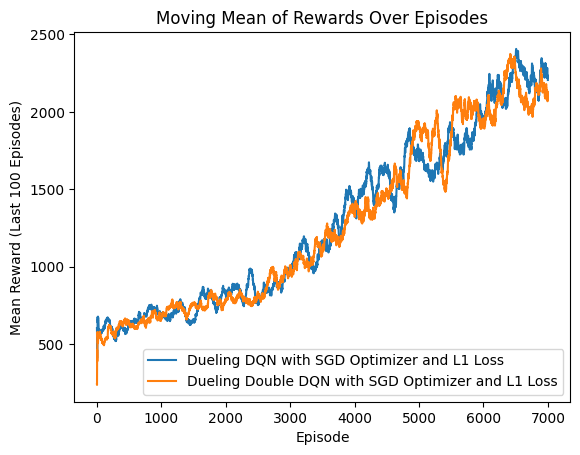

In [ ]:
plt.clf()
plt.plot(range(7000), mean_rewards_dqn_sgd_l1, label = "Dueling DQN with SGD Optimizer and L1 Loss")
plt.plot(range(7000), mean_rewards_double_dqn_sgd_l1, label = "Dueling Double DQN with SGD Optimizer and L1 Loss")
plt.xlabel('Episode')
plt.ylabel('Mean Reward (Last 100 Episodes)')
plt.title('Moving Mean of Rewards Over Episodes')
plt.legend()
plt.show()

## Make video for agent

In [ ]:
!pip install imageio
from IPython.display import display, clear_output
import imageio
import matplotlib.pyplot as plt
from google.colab import files

In [ ]:
# load the model from a file
use_cuda = torch.cuda.is_available()
agent = DoubleDQNAgent((4, 84, 84), env.action_space.n, use_cuda, 1.0, 0.9995, 0.99, 0.0005, "L1", "SGD")
agent.policy.load_state_dict(torch.load('agent_double_dqn_sgd_l1_policy.pth'))
agent.target.load_state_dict(agent.policy.state_dict())

<All keys matched successfully>

In [ ]:
# Show the best run over 100 runs
curr_r = 0
for i in range(100):
  env = gym_super_mario_bros.make("SuperMarioBros-1-1-v0")
  env = JoypadSpace(env, SIMPLE_MOVEMENT)
  env = preprocess(env)
  state = arrange(env.reset())
  # Play the game!
  frames = []
  r = 0
  while True:

      # Run agent on the state
      action = agent.select_action(state, True)
      # Agent performs action
      next_state, reward, done, info = env.step(action)
      r += reward
      # show_state(env,0)
      frame = env.render(mode='rgb_array').copy()
      frames.append(frame)
      next_state = arrange(next_state)
      # Update state
      state = next_state
      # Check if end of game
      if done or info["flag_get"]:
          break
  if r > curr_r:
      curr_r = r
      imageio.mimsave('best_run.gif', frames, fps=10)
files.download('best_run.gif')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

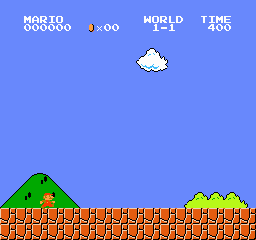

In [ ]:
from IPython.display import Image
display(Image(data=open('best_run.gif','rb').read(), format='gif'))